# **EfficientDet Object Detection**

In [1]:
#!/usr/bin/env python3

# EfficientDet Object Detection
# * Single Shot Detector with EfficientNet-b3 + BiFPN feature extractor
# * Shared box predictor and focal loss
# * Trained on COCO 2017 dataset.
#
# 2021 (c) Micha Johannes Birklbauer
# 2021 (c) The TensorFlow Authors
#
# https://github.com/t0xic-m/
# micha.birklbauer@gmail.com

import os
import cv2
import imageio
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt

In [2]:
print("loading model...")
model = hub.load("efficientdet_d3_1")
print("model successfully loaded!")

loading model...


model successfully loaded!


In [3]:
# return bounding box in shape of [ymin, xmin, ymax, xmax]
def get_box(filename):
    img = imageio.imread(filename, as_gray = False)
    img = np.reshape(img, [1, img.shape[0], img.shape[1], 3])
    prediction = model(img)

    if prediction["detection_boxes"].numpy().shape[1] > 0:
        # select first element which is = 1 => COCO class for person
        try:
            idx = np.where(prediction["detection_classes"].numpy()[0] == 1)[0][0]
            return prediction["detection_boxes"].numpy()[0][idx]
        except IndexError:
            print("No person detected!")
            return None
    else:
        return None

# return image with bounding box + save to current directory
def visualize_bbox(filename, bbox = None, show = False, save = True):
    img = imageio.imread(filename, as_gray = False)
    width = img.shape[1]
    height = img.shape[0]
    if bbox is not None:
        start_x = round(bbox[1] * width)
        start_y = round(bbox[0] * height)
        end_x = round(bbox[3] * width)
        end_y = round(bbox[2] * height)
        new_img = img.copy()
        new_img = cv2.rectangle(new_img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
        if show:
            plt.figure()
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(img)
            axarr[1].imshow(new_img)
            plt.show()   
        if save:
            imageio.imwrite(filename.split(".")[0] + "_bb.jpg", new_img)
        return new_img
    else:
        print("WARNING: No bounding box provided!")
        if save:
            imageio.imwrite(filename.split(".")[0] + "_bb.jpg", img)
        return img

## **Testing on some sample images**

In [4]:
test_1 = {"filename":"../data/test_images/dog.jpg"}
test_2 = {"filename":"../data/test_images/000001163.jpg"}
test_1["bbox"] = get_box(test_1["filename"])
test_2["bbox"] = get_box(test_2["filename"])

<Figure size 432x288 with 0 Axes>

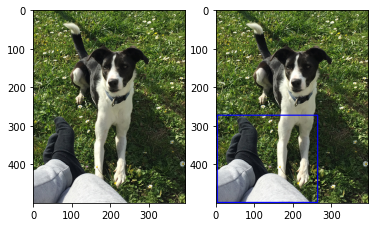

In [5]:
visualize_bbox(test_1["filename"], test_1["bbox"], show = True, save = False);

<Figure size 432x288 with 0 Axes>

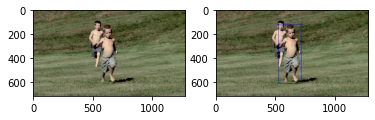

In [6]:
visualize_bbox(test_2["filename"], test_2["bbox"], show = True, save = False);

## **Testing on our test sample**

In [16]:
import pandas as pd

test_df = pd.read_csv("../data/samples_test.csv")
test_df.head()

,NAME,ymin,ymax,xmin,xmax
0,002094496.jpg,266.0,1080.0,887.0,1686.0
1,007055006.jpg,100.0,274.0,282.0,429.0
2,007349675.jpg,226.0,437.0,87.0,361.0
3,011151221.jpg,82.0,349.0,239.0,429.0
4,018050712.jpg,147.0,984.0,573.0,1919.0


In [17]:
def pred_boxes(df):
    filepath = "../data/samples_test/" + str(df["NAME"])
    img = imageio.imread(filepath, as_gray = False)
    width = img.shape[1]
    height = img.shape[0]
    bbox = get_box(filepath)
    if bbox is not None:
        df["ymin_pred"] = float(round(bbox[0] * height))
        df["ymax_pred"] = float(round(bbox[2] * height))
        df["xmin_pred"] = float(round(bbox[1] * width))
        df["xmax_pred"] = float(round(bbox[3] * width))
    return df
    
test_df = test_df.apply(pred_boxes, axis = 1)

test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred
0,002094496.jpg,266.0,1080.0,887.0,1686.0,259.0,1071.0,892.0,1700.0
1,007055006.jpg,100.0,274.0,282.0,429.0,99.0,276.0,282.0,425.0
2,007349675.jpg,226.0,437.0,87.0,361.0,227.0,440.0,89.0,361.0
3,011151221.jpg,82.0,349.0,239.0,429.0,81.0,350.0,236.0,352.0
4,018050712.jpg,147.0,984.0,573.0,1919.0,133.0,1037.0,280.0,1920.0


In [18]:
test_df.to_csv("efficientdet_results/samples_test_pred.csv", index = False)

## **Calculating mAP**

In [19]:
# implementation according to: https://datanics.blogspot.com/2020/11/understanding-mean-average-precision.html

# jaccard index
def IoU(df):
    # determining the minimum and maximum -coordinates of the intersection rectangle
    xmin_inter = max(df["xmin"], df["xmin_pred"])
    ymin_inter = max(df["ymin"], df["ymin_pred"])
    xmax_inter = min(df["xmax"], df["xmax_pred"])
    ymax_inter = min(df["ymax"], df["ymax_pred"])
 
    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1)
 
    # calculate area of actual and predicted boxes
    actual_area = (df["xmax"] - df["xmin"] + 1) * (df["ymax"] - df["ymin"] + 1)
    pred_area = (df["xmax_pred"] - df["xmin_pred"] + 1) * (df["ymax_pred"] - df["ymin_pred"] + 1)
 
    # computing intersection over union
    iou = inter_area / float(actual_area + pred_area - inter_area)
 
    # return the intersection over union value
    return iou

test_df["IoU"] = test_df.apply(IoU, axis = 1)
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU
0,002094496.jpg,266.0,1080.0,887.0,1686.0,259.0,1071.0,892.0,1700.0,0.957879
1,007055006.jpg,100.0,274.0,282.0,429.0,99.0,276.0,282.0,425.0,0.957010
2,007349675.jpg,226.0,437.0,87.0,361.0,227.0,440.0,89.0,361.0,0.974357
3,011151221.jpg,82.0,349.0,239.0,429.0,81.0,350.0,236.0,352.0,0.584996
4,018050712.jpg,147.0,984.0,573.0,1919.0,133.0,1037.0,280.0,1920.0,0.760072


In [20]:
# creating column 'TP/FP' which will store TP for True positive and FP for False positive
# if IOU is greater than 0.5 then TP else FP
test_df["TP/FP"] = test_df["IoU"].apply(lambda x: "TP" if x >= 0.5 else "FP")
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP
0,002094496.jpg,266.0,1080.0,887.0,1686.0,259.0,1071.0,892.0,1700.0,0.957879,TP
1,007055006.jpg,100.0,274.0,282.0,429.0,99.0,276.0,282.0,425.0,0.957010,TP
2,007349675.jpg,226.0,437.0,87.0,361.0,227.0,440.0,89.0,361.0,0.974357,TP
3,011151221.jpg,82.0,349.0,239.0,429.0,81.0,350.0,236.0,352.0,0.584996,TP
4,018050712.jpg,147.0,984.0,573.0,1919.0,133.0,1037.0,280.0,1920.0,0.760072,TP


In [21]:
# calculating Precision and recall
Precision = []
Recall = []

TP = FP = 0
FN = len(test_df["TP/FP"] == "TP")
for index , row in test_df.iterrows():     
    if row["IoU"] > 0.5:
        TP = TP + 1
    else:
        FP = FP + 1    

    try:
        AP = TP / (TP + FP)
        Rec = TP / (TP + FN)
    except ZeroDivisionError:
        AP = Recall = 0.0
    
    Precision.append(AP)
    Recall.append(Rec)


test_df["Precision"] = Precision
test_df["Recall"] = Recall

test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP,Precision,Recall
0,002094496.jpg,266.0,1080.0,887.0,1686.0,259.0,1071.0,892.0,1700.0,0.957879,TP,1.0,0.019608
1,007055006.jpg,100.0,274.0,282.0,429.0,99.0,276.0,282.0,425.0,0.957010,TP,1.0,0.038462
2,007349675.jpg,226.0,437.0,87.0,361.0,227.0,440.0,89.0,361.0,0.974357,TP,1.0,0.056604
3,011151221.jpg,82.0,349.0,239.0,429.0,81.0,350.0,236.0,352.0,0.584996,TP,1.0,0.074074
4,018050712.jpg,147.0,984.0,573.0,1919.0,133.0,1037.0,280.0,1920.0,0.760072,TP,1.0,0.090909


In [22]:
#calculating Interpolated Precision
test_df["Precision_interpol"] = test_df.groupby("Recall")["Precision"].transform("max")
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP,Precision,Recall,Precision_interpol
0,002094496.jpg,266.0,1080.0,887.0,1686.0,259.0,1071.0,892.0,1700.0,0.957879,TP,1.0,0.019608,1.0
1,007055006.jpg,100.0,274.0,282.0,429.0,99.0,276.0,282.0,425.0,0.957010,TP,1.0,0.038462,1.0
2,007349675.jpg,226.0,437.0,87.0,361.0,227.0,440.0,89.0,361.0,0.974357,TP,1.0,0.056604,1.0
3,011151221.jpg,82.0,349.0,239.0,429.0,81.0,350.0,236.0,352.0,0.584996,TP,1.0,0.074074,1.0
4,018050712.jpg,147.0,984.0,573.0,1919.0,133.0,1037.0,280.0,1920.0,0.760072,TP,1.0,0.090909,1.0


In [23]:
prec_at_rec = []

for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        x = test_df[test_df["Recall"] >= recall_level]["Precision"]
        prec = max(x)
    except:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)
print("11 point precision is ", prec_at_rec)
print("mAP is ", avg_prec)

11 point precision is  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP is  0.5454545454545454


In [24]:
test_df.to_csv("efficientdet_results/samples_test_pred2.csv", index = False)